In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, trainDenoising, OrthoLoss, init_train_hist
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg.copy_and_resolve_references()

#Set model specific config
n_hidden = 10
cfg.enc_hidden_dim = list(np.linspace(cfg.obs_dim,cfg.factor_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim = list(np.linspace(cfg.factor_dim,cfg.obs_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.enc_activation = nn.Sigmoid
cfg.dec_activation = nn.Sigmoid
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = True

#set experiment specifig training params
cfg.lr = 0.0008
cfg.n_epoch = 50
cfg.max_iter = 10
cfg.saved_index = 30
cfg.use_default_data  = True
cfg.batch_size = 128

cfg.T_train = 1000

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(1000, 50) (1024, 50) (14360, 50)


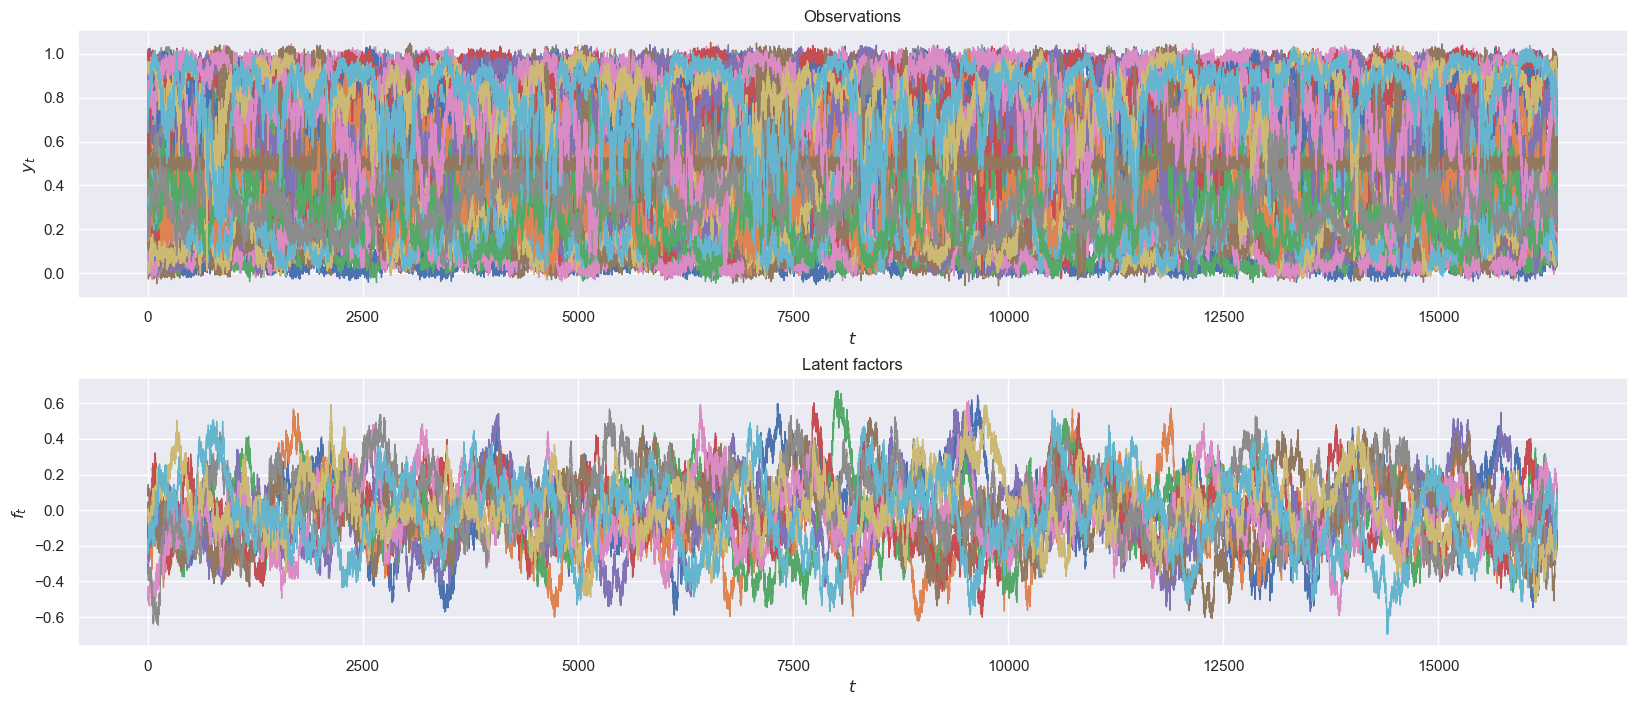

In [37]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=False, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

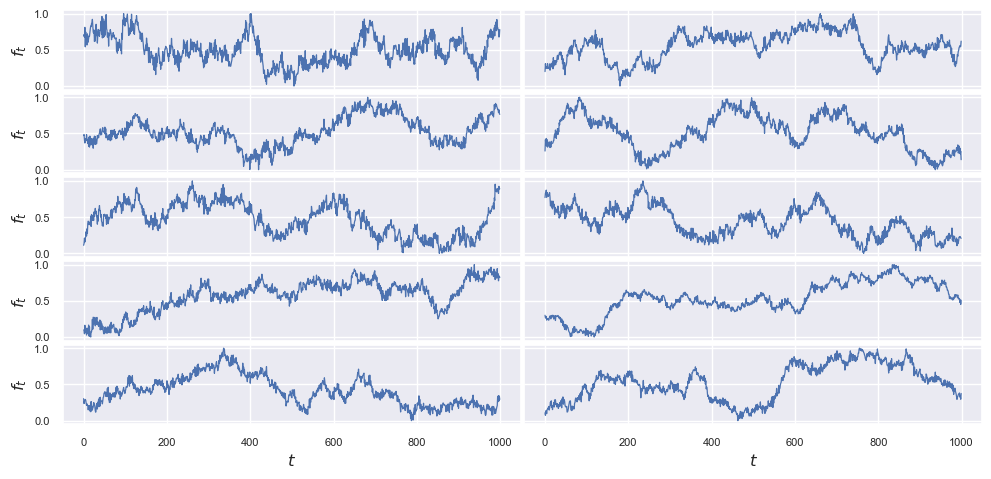

In [75]:
nCols = 2
offset = 0
fig,axs = plt.subplots(int(cfg.factor_dim/nCols),nCols, sharey=True, sharex=True, figsize=(10,5))
for i, ax in enumerate(axs.flatten()):
    f_use = f[offset:offset+cfg.T_train,i]
    f_use = (f_use-f_use.min())/(f_use.max()-f_use.min())
    ax.plot(f_use, linewidth=0.9)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$f_t$')
        ax.tick_params(labelsize=8)
        
        
        
fig.tight_layout()
plt.subplots_adjust(wspace=0.008, hspace=0.05);
axs.flatten()[-1].tick_params(labelsize=8)

#plt.ylim(-1,1);


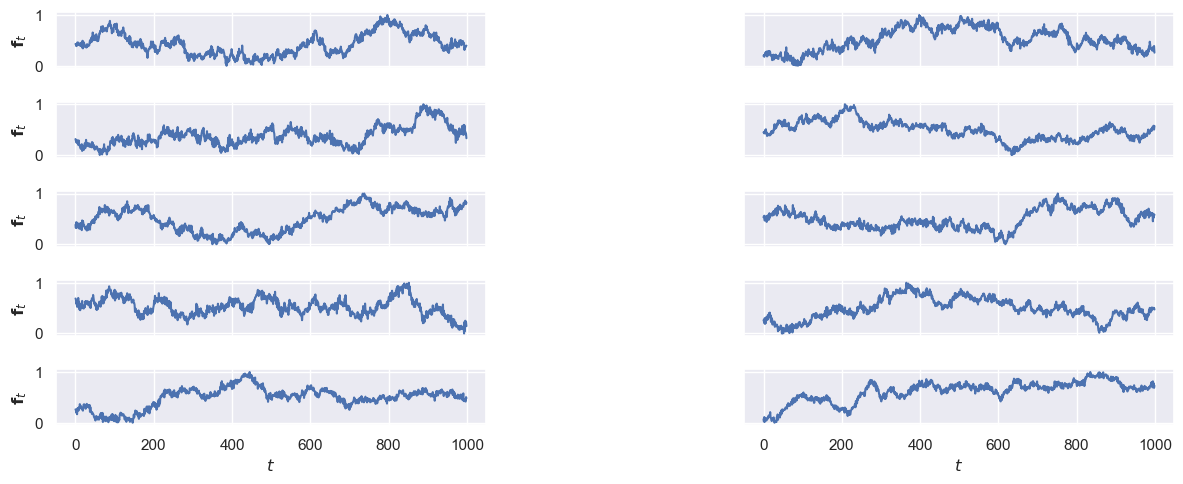

In [45]:
nCols = 2
offset = 5000
fig,axs = plt.subplots(int(cfg.factor_dim/nCols),nCols, sharey=True, sharex=True, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    f_use = f[offset:offset+cfg.T_train,i]
    f_use = (f_use-f_use.min())/(f_use.max()-f_use.min())
    ax.plot(f_use)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$\mathbf{f}_t$')
        
fig.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=0.6)

#plt.ylim(-1,1);

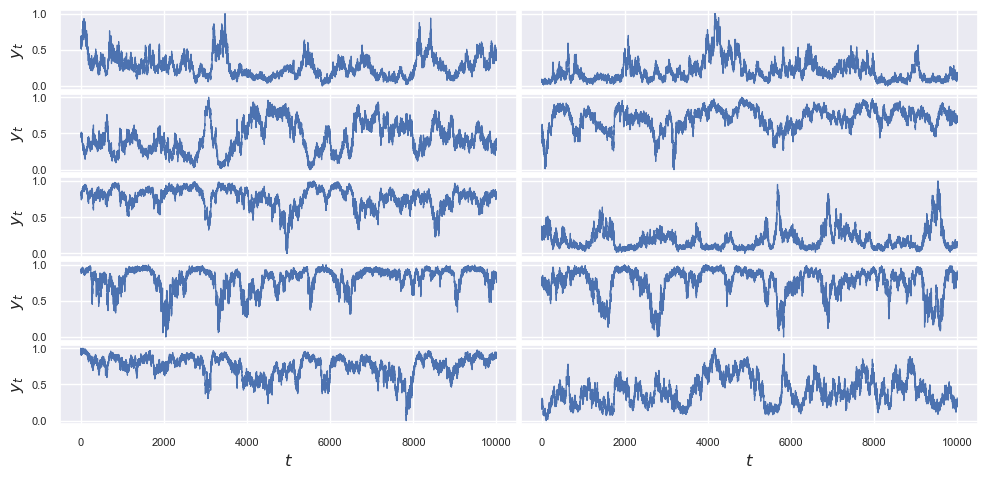

In [78]:
sns.set()
nCols = 2
offset = 5000
nShow = 10
T = 10000
fig,axs = plt.subplots(int(nShow/nCols),nCols, sharey=True, sharex=True, figsize=(10,5))#, figsize=(12,5*nShow/10))
for i, ax in enumerate(axs.flatten()):
    y_use = y[offset:offset+T,i]
    y_use = (y_use-y_use.min())/(y_use.max()-y_use.min())
    ax.plot(y_use, linewidth=0.9)
    #ax.set_ylabel('$\mathbf{f}_t$')
    if i >= len(axs.flatten())-nCols:
        ax.set_xlabel('$t$')
    if i % nCols == 0:
        ax.set_ylabel('$y_t$')
        ax.tick_params(labelsize=8)
        
        
        
fig.tight_layout()
plt.subplots_adjust(wspace=0.008, hspace=0.05);
axs.flatten()[-1].tick_params(labelsize=8)

#plt.ylim(-1,1);
